In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
    %tensorflow_version 2.x  # Colab only.
except Exception:
    pass

import tensorflow as tf
print(tf.__version__)

2.3.1


In [17]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')

In [3]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


#### Now let's try an LSTM to predict "close"

In [5]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [8]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [15]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, D) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


#### LTSM (T = 10)

In [16]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', 
              optimizer=Adam(lr=0.1))

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 38ms/step - loss: 0.2895 - val_loss: 0.7369
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0263 - val_loss: 0.0770
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0566
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0637
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0514
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0412
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0439
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0735
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0484
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0516
Epoch 11/80
20/20 

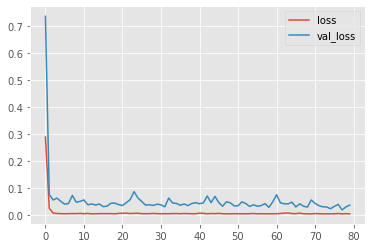

In [18]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


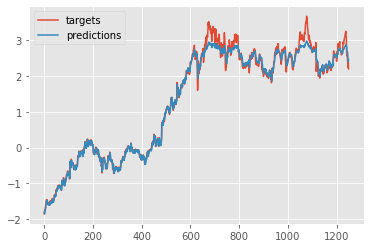

In [19]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

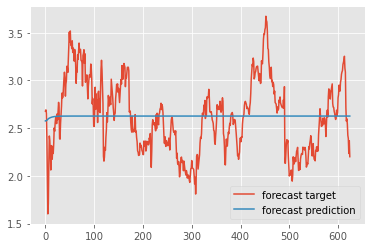

In [20]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, T, 1))[0,0]    # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [21]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [22]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [23]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [24]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


#### Now let's try an LSTM to predict "returns"

<AxesSubplot:>

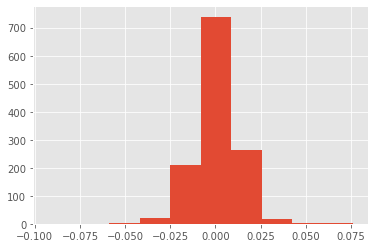

In [25]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [26]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [27]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [28]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 34ms/step - loss: 1.0084 - val_loss: 1.1491
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9860 - val_loss: 1.1503
Epoch 3/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9883 - val_loss: 1.1477
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9842 - val_loss: 1.1521
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9822 - val_loss: 1.1473
Epoch 6/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9839 - val_loss: 1.1551
Epoch 7/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9829 - val_loss: 1.1457
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9826 - val_loss: 1.1649
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9855 - val_loss: 1.1531
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9800 - val_loss: 1.1550
Epoch 11/80
20/20 

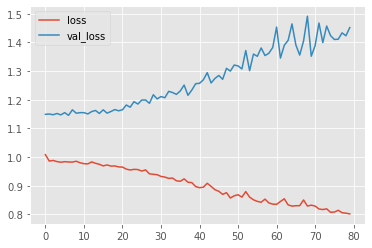

In [29]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


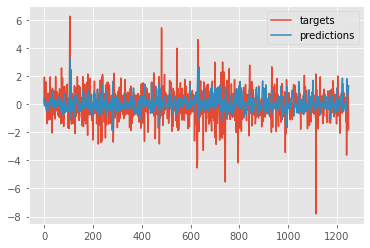

In [30]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

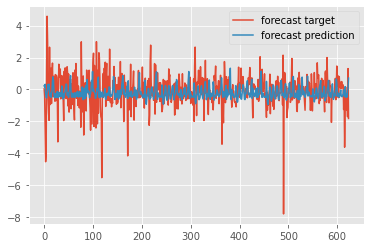

In [31]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

#### Now turn the full data into numpy arrays

In [34]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

input_data.shape

(1259, 5)

In [35]:
# Now make the actual data which will go into the neural network
T = 10    # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T   # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [37]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [44]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
    X_train[t, :, :] = input_data[t:t+T]
    Y_train[t] = (targets[t+T] > 0)

In [40]:
np.zeros((Ntrain, T, D)).shape

(839, 10, 5)

In [41]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
    # u counts from 0...(N - Ntrain)
    # t counts from Ntrain...N
    t = u + Ntrain
    X_test[u, :, :] = input_data[t:t+T]
    Y_test[u] = (targets[t+T] > 0)

In [42]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [45]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 31ms/step - loss: 0.6995 - accuracy: 0.4720 - val_loss: 0.6942 - val_accuracy: 0.4780
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5256 - val_loss: 0.6960 - val_accuracy: 0.4976
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5232 - val_loss: 0.6967 - val_accuracy: 0.4854
Epoch 4/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5292 - val_loss: 0.6920 - val_accuracy: 0.5146
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5340 - val_loss: 0.6960 - val_accuracy: 0.4927
Epoch 6/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5328 - val_loss: 0.6902 - val_accuracy: 0.5268
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5471 - val_loss: 0.6923 - val_accuracy: 0.5024
Epoch 8/300


Epoch 59/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6684 - accuracy: 0.5673 - val_loss: 0.7055 - val_accuracy: 0.4976
Epoch 60/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6677 - accuracy: 0.5840 - val_loss: 0.7069 - val_accuracy: 0.4902
Epoch 61/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6650 - accuracy: 0.5769 - val_loss: 0.7004 - val_accuracy: 0.4927
Epoch 62/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6630 - accuracy: 0.5840 - val_loss: 0.7068 - val_accuracy: 0.4878
Epoch 63/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6632 - accuracy: 0.5864 - val_loss: 0.7035 - val_accuracy: 0.5024
Epoch 64/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6648 - accuracy: 0.5757 - val_loss: 0.7029 - val_accuracy: 0.4927
Epoch 65/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6633 - accuracy: 0.5888 - val_loss: 0.7055 - val_accuracy: 0.4976
Epoch 

27/27 [==============================] - 0s 7ms/step - loss: 0.5777 - accuracy: 0.6853 - val_loss: 0.7846 - val_accuracy: 0.4659
Epoch 117/300
27/27 [==============================] - 0s 7ms/step - loss: 0.5801 - accuracy: 0.6841 - val_loss: 0.7836 - val_accuracy: 0.4829
Epoch 118/300
27/27 [==============================] - 0s 7ms/step - loss: 0.5736 - accuracy: 0.6710 - val_loss: 0.7768 - val_accuracy: 0.4829
Epoch 119/300
27/27 [==============================] - 0s 7ms/step - loss: 0.5692 - accuracy: 0.6865 - val_loss: 0.7747 - val_accuracy: 0.4951
Epoch 120/300
27/27 [==============================] - 0s 6ms/step - loss: 0.5695 - accuracy: 0.6794 - val_loss: 0.7750 - val_accuracy: 0.4756
Epoch 121/300
27/27 [==============================] - 0s 6ms/step - loss: 0.5666 - accuracy: 0.6830 - val_loss: 0.7830 - val_accuracy: 0.4878
Epoch 122/300
27/27 [==============================] - 0s 6ms/step - loss: 0.5589 - accuracy: 0.6889 - val_loss: 0.7764 - val_accuracy: 0.4902
Epoch 123/300

27/27 [==============================] - 0s 6ms/step - loss: 0.4104 - accuracy: 0.8010 - val_loss: 0.8840 - val_accuracy: 0.5146
Epoch 174/300
27/27 [==============================] - 0s 6ms/step - loss: 0.4115 - accuracy: 0.7950 - val_loss: 0.8944 - val_accuracy: 0.5244
Epoch 175/300
27/27 [==============================] - 0s 6ms/step - loss: 0.3991 - accuracy: 0.8093 - val_loss: 0.8844 - val_accuracy: 0.5220
Epoch 176/300
27/27 [==============================] - 0s 6ms/step - loss: 0.4058 - accuracy: 0.7950 - val_loss: 0.8916 - val_accuracy: 0.5317
Epoch 177/300
27/27 [==============================] - 0s 6ms/step - loss: 0.3971 - accuracy: 0.8045 - val_loss: 0.9196 - val_accuracy: 0.5317
Epoch 178/300
27/27 [==============================] - 0s 6ms/step - loss: 0.3908 - accuracy: 0.8188 - val_loss: 0.9028 - val_accuracy: 0.5244
Epoch 179/300
27/27 [==============================] - 0s 7ms/step - loss: 0.3868 - accuracy: 0.8260 - val_loss: 0.9194 - val_accuracy: 0.5293
Epoch 180/300

27/27 [==============================] - 0s 6ms/step - loss: 0.2510 - accuracy: 0.8999 - val_loss: 1.1385 - val_accuracy: 0.5220
Epoch 231/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2431 - accuracy: 0.8999 - val_loss: 1.1419 - val_accuracy: 0.5268
Epoch 232/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2424 - accuracy: 0.9011 - val_loss: 1.1466 - val_accuracy: 0.5073
Epoch 233/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2571 - accuracy: 0.8927 - val_loss: 1.1683 - val_accuracy: 0.4976
Epoch 234/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2786 - accuracy: 0.8749 - val_loss: 1.1877 - val_accuracy: 0.5244
Epoch 235/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2698 - accuracy: 0.8772 - val_loss: 1.1637 - val_accuracy: 0.5195
Epoch 236/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2568 - accuracy: 0.8951 - val_loss: 1.1719 - val_accuracy: 0.5122
Epoch 237/300

27/27 [==============================] - 0s 6ms/step - loss: 0.1742 - accuracy: 0.9285 - val_loss: 1.5167 - val_accuracy: 0.4878
Epoch 288/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1665 - accuracy: 0.9321 - val_loss: 1.5486 - val_accuracy: 0.5171
Epoch 289/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1431 - accuracy: 0.9476 - val_loss: 1.5135 - val_accuracy: 0.4829
Epoch 290/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1327 - accuracy: 0.9535 - val_loss: 1.5599 - val_accuracy: 0.4951
Epoch 291/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1492 - accuracy: 0.9535 - val_loss: 1.5523 - val_accuracy: 0.5024
Epoch 292/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1677 - accuracy: 0.9297 - val_loss: 1.5232 - val_accuracy: 0.5098
Epoch 293/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1953 - accuracy: 0.9285 - val_loss: 1.5613 - val_accuracy: 0.4976
Epoch 294/300

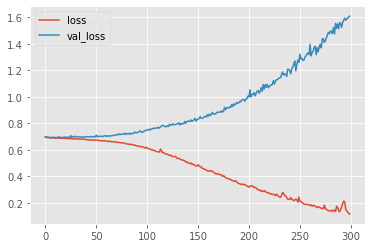

In [46]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

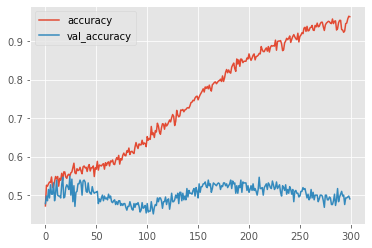

In [47]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()